In [49]:
import sys
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('../')

from dstft.loss import entropy_loss, entropyt_loss, kurtosis_loss
from dstft import DSTFT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([1, 6767]) cuda:0 torch.float32
[0, 1031, 1615, 2768, 3403, 3764, 5560, 6767]


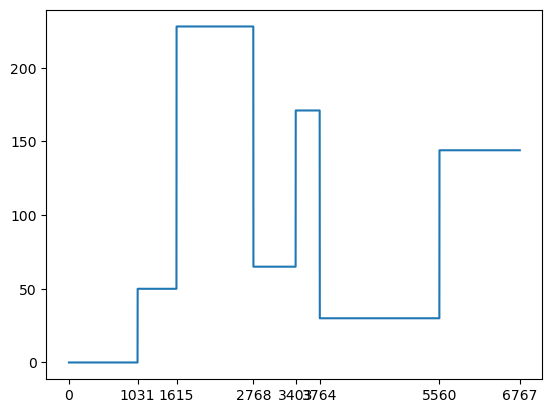

In [50]:
sr = 1e3
sizes = [1031, 584, 1153, 635, 361, 1796, 1207]
freqs = [0, 50, 228, 65, 171, 30, 144,]
f = freqs[0] * (torch.ones(sizes[0]) + .0 * torch.randn(sizes[0]))
for i in range(1, len(freqs)):
    f = torch.cat((f, freqs[i]  * (torch.ones(sizes[i]) + .0 * torch.randn(sizes[i]))))
f = f + 0. * torch.ones_like(f) * torch.randn_like(f)

x = torch.sin(2*pi*torch.cumsum(f, 0)/sr)
x += 0.2 * torch.randn(x.shape)
x = x[None, :].to(device)
print(x.shape, x.device, x.dtype)

mark_list = np.cumsum(sizes).tolist()
mark_list.insert(0, 0)
print(mark_list)

plt.figure()
plt.plot(f)
plt.xticks(mark_list)
plt.show()

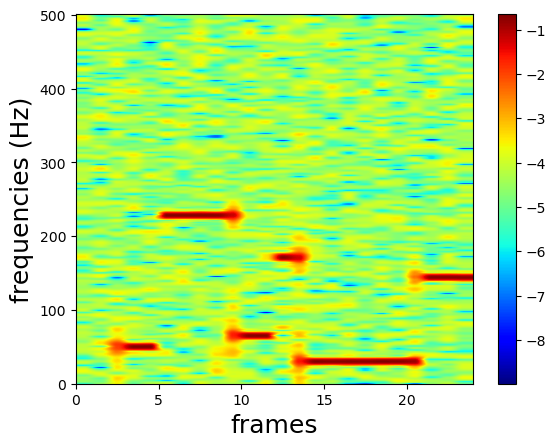

In [51]:
dstft = DSTFT(x, win_length=300, support=1_000, stride=250, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

Time-varying window length

Epoch 00275: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00278: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00280: reducing learning rate of group 0 to 1.0000e-02.
279


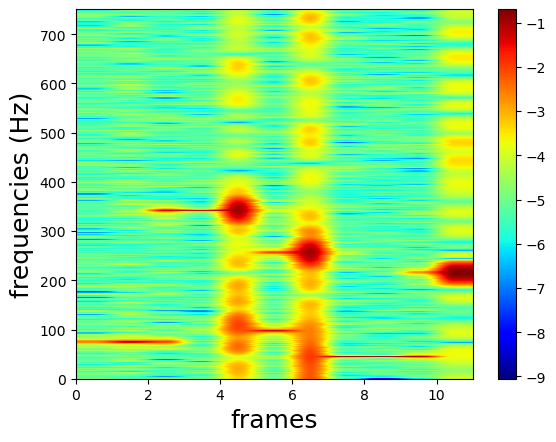

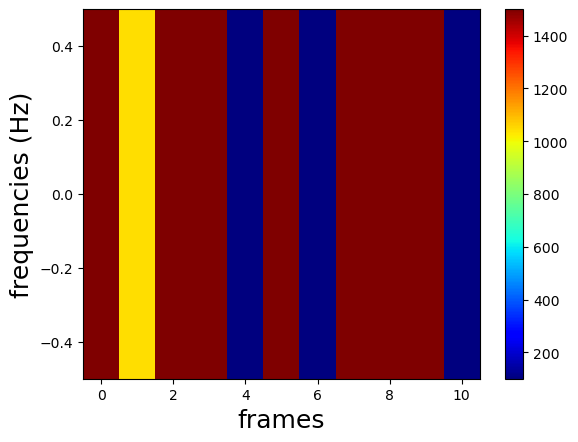

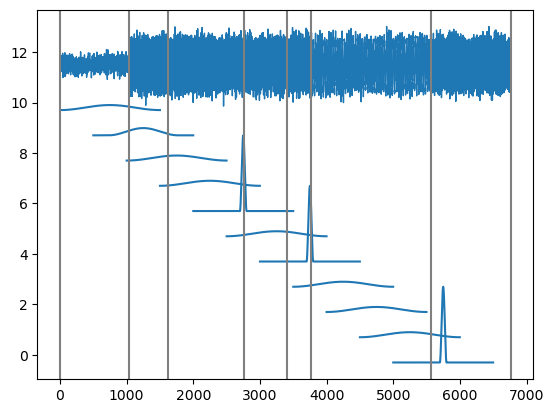

In [52]:
dstft = DSTFT(x, win_length=500, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 10.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=1, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 100 / kurtosis_loss(spec) #+ 0.00001 * (spec.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

time-varying hop length

tensor(374.7801, device='cuda:0', grad_fn=<MulBackward0>)
tensor(355.6051, device='cuda:0', grad_fn=<MulBackward0>)
tensor(355.2533, device='cuda:0', grad_fn=<MulBackward0>)
tensor(351.0162, device='cuda:0', grad_fn=<MulBackward0>)
tensor(349.8425, device='cuda:0', grad_fn=<MulBackward0>)
tensor(349.7724, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00516: reducing learning rate of group 0 to 8.0000e+00.
tensor(349.7724, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00616: reducing learning rate of group 0 to 4.0000e+00.
tensor(349.7724, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00716: reducing learning rate of group 0 to 2.0000e+00.
tensor(349.7724, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00816: reducing learning rate of group 0 to 1.0000e+00.
tensor(349.7724, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00916: reducing learning rate of group 0 to 5.0000e-01.
tensor(349.7725, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 01016: reducing learning rate of group 0 to 2.

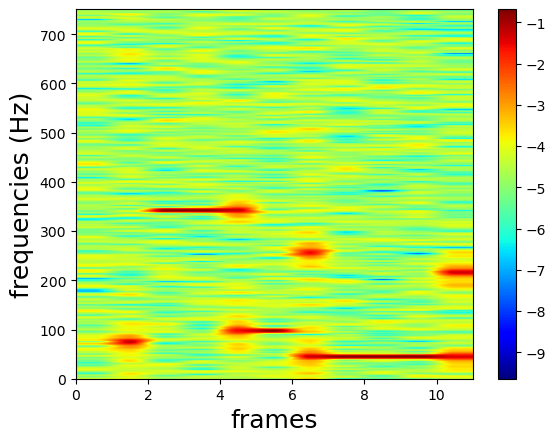

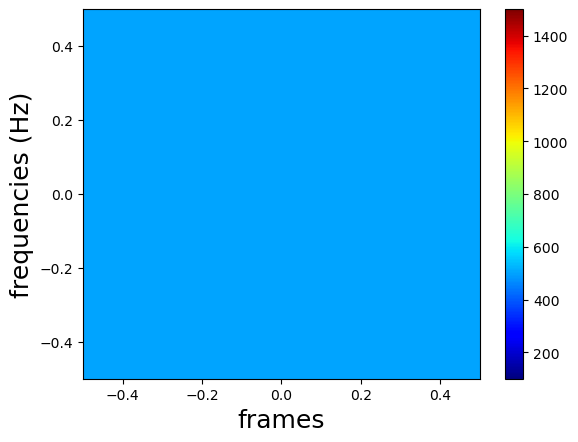

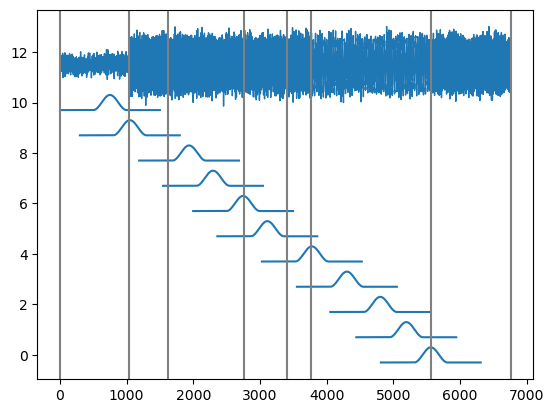

In [54]:
dstft = DSTFT(x, win_length=500, support=1_500, stride=500, win_requires_grad=False, stride_requires_grad=True, stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 16.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec) #+ 0.00001 * (spec.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    if epoch % 100 == 0: print(err)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
print(dstft.actual_strides)
dstft.print(spec, x, marklist=mark_list, bar=True)

Time-varying window and hop length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 8.0}, {'params': dstft.strides, 'lr': 16.0}] #  [ {'params': dstft.parameters(),    'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=9, verbose=True)



for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1000 / kurtosis_loss(spec)
    print(err)
    err.backward()
    opt.step()
    sch.step(err)
    

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

tensor(363.3789, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00006: reducing learning rate of group 0 to 4.0000e+00.
tensor(123.3434, device='cuda:0', grad_fn=<MulBackward0>)
tensor(108.7541, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00220: reducing learning rate of group 0 to 2.0000e+00.
tensor(106.0193, device='cuda:0', grad_fn=<MulBackward0>)
tensor(103.8511, device='cuda:0', grad_fn=<MulBackward0>)
tensor(101.9602, device='cuda:0', grad_fn=<MulBackward0>)
tensor(100.3774, device='cuda:0', grad_fn=<MulBackward0>)
tensor(99.2497, device='cuda:0', grad_fn=<MulBackward0>)
Epoch 00740: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00743: reducing learning rate of group 0 to 5.0000e-01.
end
742


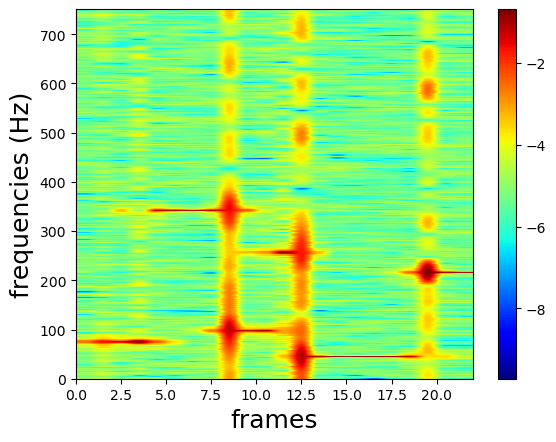

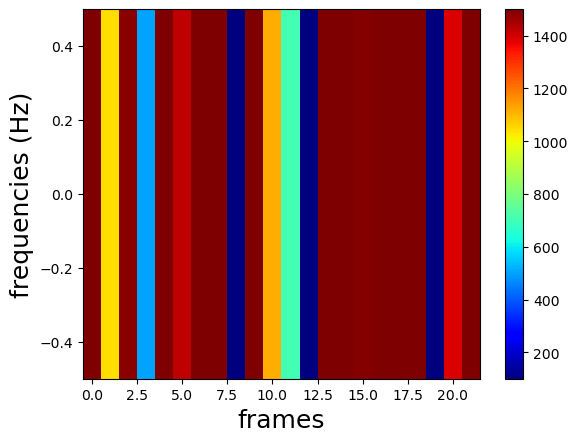

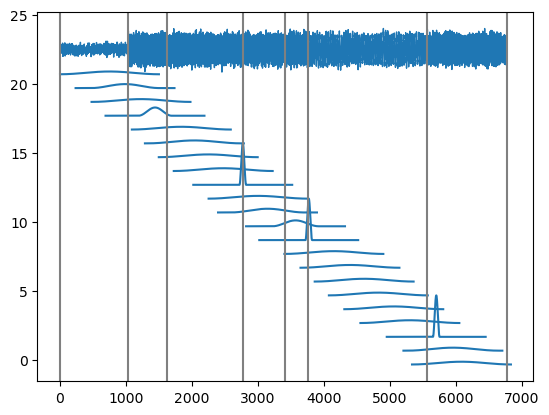

In [61]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)

params1 = [{'params': dstft.win_length, 'lr': 4.0}]
opt1 = torch.optim.Adam(params1)
sch1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt1, mode='min', factor=.5, patience=9, verbose=True)

params2 = [{'params': dstft.strides, 'lr': 8.0}]
opt2 = torch.optim.Adam(params2)
sch2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt2, mode='min', factor=.5, patience=1, verbose=True)

for epoch in range(10_000):
    opt1.zero_grad()  
    opt2.zero_grad()
    spec, *_ = dstft(x)
    err = 1000 / kurtosis_loss(spec)
    if epoch % 100 == 0: print(err)
    err.backward()
    opt1.step()
    sch1.step(err)
    opt2.step()
    sch2.step(err)
    
    if opt2.param_groups[0]['lr'] < 1:
        print('end')
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
print(dstft.actual_strides)

Time-and-frequency varying window length and time-varying hop length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 4.0}, {'params': dstft.strides, 'lr': 4.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=1, verbose=True)

for epoch in range(100_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)